In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib import cm
from matplotlib.pyplot import figure
from xml.etree import ElementTree as et
from xml.dom import minidom
from scipy.spatial.transform import Rotation as R
%matplotlib inline

In [2]:
def quaternion_from_vector(vector_2d):
    vec1=np.array([1, 0, 0])
    vec2=np.array([vector_2d[0], vector_2d[1], 0])
    
    vec1 = np.reshape(vec1, (1, -1))
    vec2 = np.reshape(vec2, (1, -1))
    
    r = R.align_vectors(vec2, vec1)
    return r[0].as_quat()

def read_path_x_y_yaw_s(file_name):
    f = open(file_name)
    success = False
    xs = []
    ys = []
    yaws = []
    for line in f:
        if line.split()[0] == "False":
            success = False
            break
        if line.split()[0] == "True":
            success = True
            break
        
        x, y, yaw = list(map(float, line.split()))
        xs.append(x)
        ys.append(y)
        yaws.append(yaw)
        
    return xs, ys, yaws, success
        
def get_height(x, y, resolution, height_map):
    len_x = height_map.shape[0] * resolution
    len_y = height_map.shape[1] * resolution
    i, j = get_ij(x, y, resolution,len_x, len_y)
    return height_map[i, j]

def get_ij(x, y, resolution, len_x, len_y):
    i = int((len_x/2 - x) / resolution)
    j = int((len_y/2 - y) / resolution)
    return i, j
    

def convert_path_to_x_y_z(xs, ys, resolution, height_map):
    steps = len(xs)
    x = np.array(xs)
    y = np.array(ys)
    z = np.array([get_height(x[i], y[i], resolution, height_map) for i in range(len(xs))])
    
    path = np.vstack((x, y, z))
    path = np.transpose(path)
    
    return path

def draw_map_2d(height_map, resolution):
    min_x = -height_map.shape[0]/2 * resolution
    max_x = height_map.shape[0]/2  * resolution
    min_y = -height_map.shape[1]/2  * resolution
    max_y = height_map.shape[1]/2  * resolution

    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    p = plt.imshow(height_map, cmap='jet', extent=[max_y, min_y, min_x, max_x])
    plt.colorbar(p)
    
    return fig, ax
    

    
    

# Карты

## Карта 1

In [3]:

map_size_1 = (200, 200) # pixels
map_1 = np.zeros(map_size_1)
resolution = 0.05 # meters

center = (100, 100) # pixels
r_big = 70 # pixels
r_small = 30 # pixels
top_height = 2.5 # meters

full_height = r_big/(r_big - r_small) * top_height

for i in range(map_size_1[0]):
    for j in range(map_size_1[1]):
        if ((i - center[0]) ** 2 + (j - center[1]) ** 2 <= r_big ** 2 ):
            if ((i - center[0]) ** 2 + (j - center[1]) ** 2 <= r_small ** 2 ):
                map_1[i, j] = top_height
            else:
                v = np.array([(i - center[0]), (j - center[1])])
                dist = r_big - np.linalg.norm(v)
                map_1[i, j] = dist/r_big * full_height
            
            
min_x_1 = -map_size_1[0]/2 * resolution
max_x_1 = map_size_1[0]/2  * resolution
min_y_1 = -map_size_1[0]/2  * resolution
max_y_1 = map_size_1[0]/2  * resolution

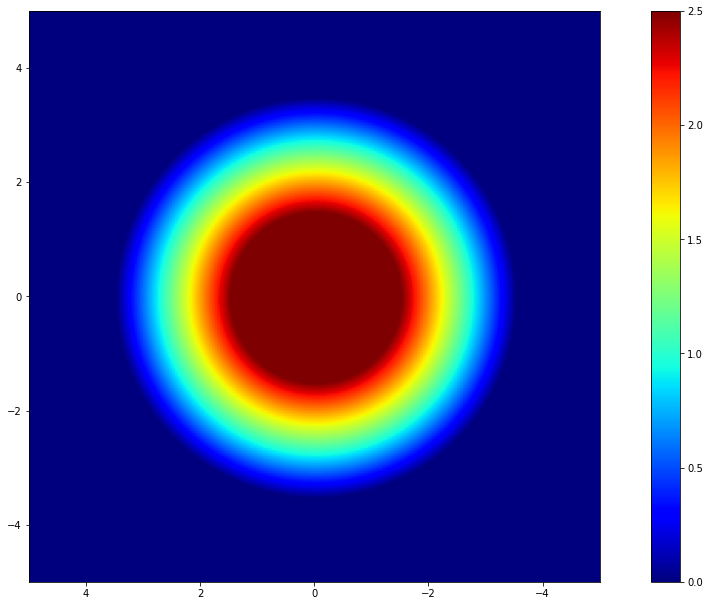

In [4]:
draw_map_2d(map_1, resolution)
plt.show()

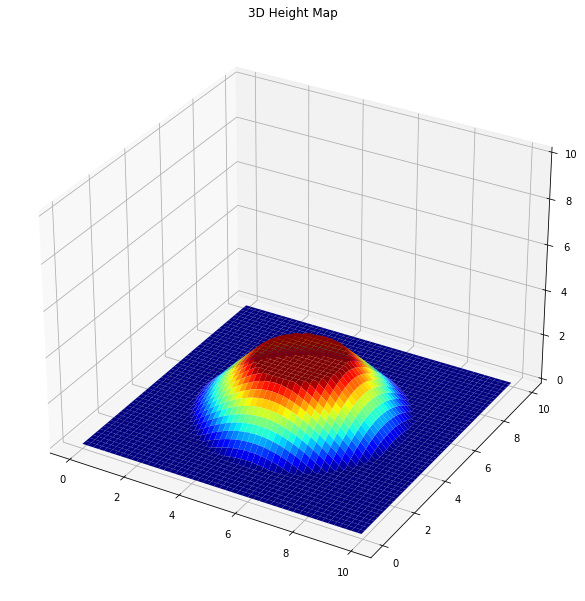

In [5]:
z = map_1
x_real = resolution * np.array(range(z.shape[0]))
y_real = resolution * np.array(range(z.shape[1]))
x, y = np.meshgrid(x_real, y_real)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='jet')
ax.set_zlim(0, 10)

plt.title('3D Height Map')
plt.show()


## Карта 2

In [6]:
map_size_2 = (240, 160) # pixels
map_2 = np.zeros(map_size_2) 
resolution = 0.05 # meters

box_height = 0.5 # meters
box_len = 100 # pixels

center_j = map_size_2[1] // 2 

ramp_len = 100 # pixels
box_width = 80 # pixels

map_2[:box_len, :] = box_height

for i in range(box_len, box_len + ramp_len):
    for j in range(center_j - box_width // 2,  center_j + box_width // 2):
        map_2[i, j] = -(i - box_len - ramp_len) / ramp_len * box_height


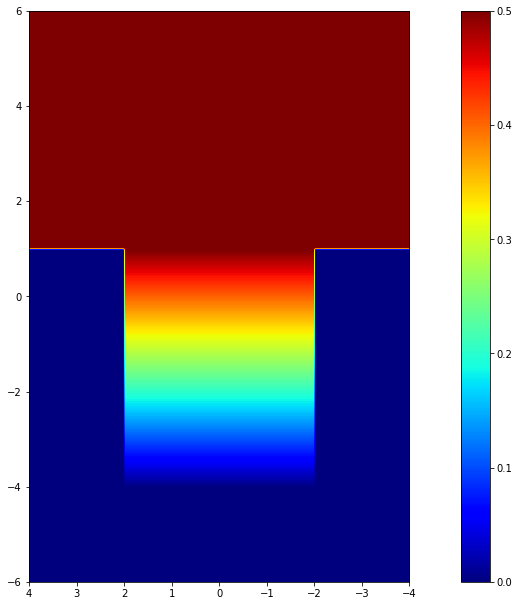

In [7]:
draw_map_2d(map_2, resolution)
plt.show()

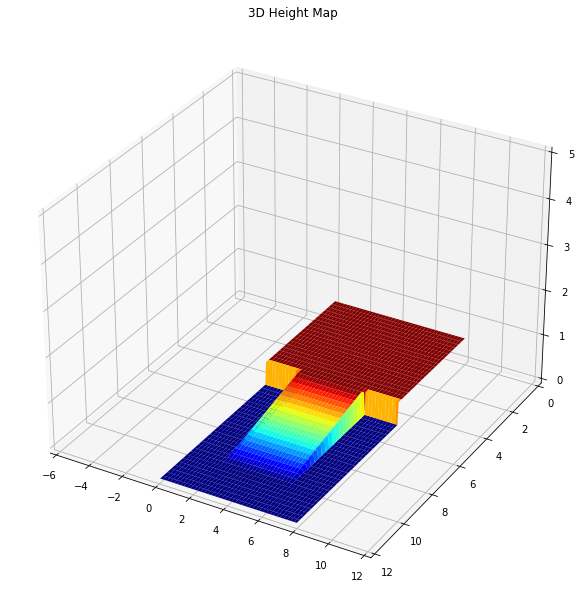

In [8]:
z = map_2
x_real = resolution * np.array(range(z.shape[1]))
y_real = resolution * np.array(range(z.shape[0]))
x, y = np.meshgrid(x_real, y_real)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='jet')
ax.set_zlim(0,5)
ax.set_ylim(z.shape[0] * resolution ,0)
ax.set_xlim(-z.shape[0] * resolution/2, z.shape[0] * resolution)

plt.title('3D Height Map')
plt.show()

## Карта 3

In [9]:
map_size_3 = (240, 100) # pixels
map_3 = np.zeros(map_size_3)
resolution = 0.05 # meters

hole_center = (120, 35) # pixels
hole_half_size = (5, 35) # pixels
hole_depth = 0.1 # meters

map_3[hole_center[0] - hole_half_size[0]:hole_center[0] + hole_half_size[0], 
      hole_center[1] - hole_half_size[1]:hole_center[1] + hole_half_size[1]] = -hole_depth


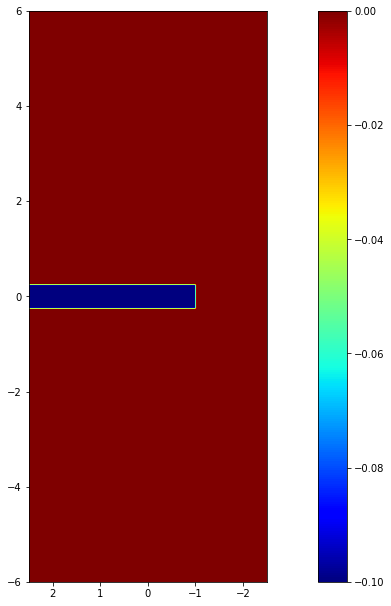

In [10]:
draw_map_2d(map_3, resolution)
plt.show()

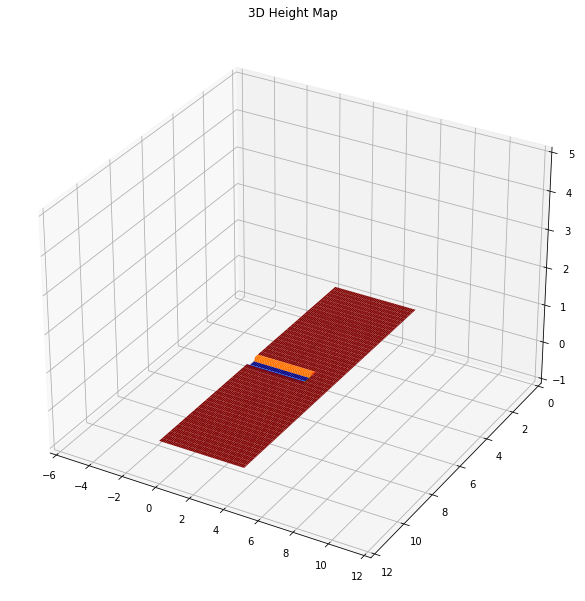

In [11]:
z = map_3
x_real = resolution * np.array(range(z.shape[1]))
y_real = resolution * np.array(range(z.shape[0]))
x, y = np.meshgrid(x_real, y_real)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='jet')
ax.set_zlim(-1,5)
ax.set_ylim(z.shape[0] * resolution ,0)
ax.set_xlim(-z.shape[0] * resolution/2, z.shape[0] * resolution)

plt.title('3D Height Map')
plt.show()

# Оценки путей

- Средний перепад высот $H$
- Длина пути $L$
- Симуляционное время в пути $T$
- Средний наклон $S$ и отклониение футпринта $R$ (?)

## Максимальный перепад высот

$$
H(\pi) = \max_{i = 0...n-2}{\Delta z(\pi_i, \pi_{i+1})}
$$



 - $\pi$ - полученный путь
 - $n$ - число шагов в пути

In [12]:
def max_height_diff(path):
    max_dz = 0.0 
    for i in range(len(path)-1):
        z_prev = path[i][2]
        z = path[i+1][2]
        dz = abs(z_prev - z)
        if dz > max_dz:
            max_dz = dz
        
    return max_dz

## Длина пути

- Расчитывается только для путей, где не содержится слишком больших перепадов высот между шагами
- Учет перепада высоты в длине пути

$$
L(\pi) = \sum_{i = 0}^{n-1}{dist(\pi_i, \pi_{i+1})}
$$

$$
dist(a, b) = \sqrt{(a_x - b_x)^2 + (a_y - b_y)^2 + (a_z - b_z)^2}
$$

 - $\pi$ - полученный путь
 - $n$ - число шагов в пути

In [13]:
def path_len(path):
    res = 0.0
    for i in range(len(path)-1):
        x_prev = path[i][0]
        y_prev = path[i][1]
        z_prev = path[i][2]
        x = path[i+1][0]
        y = path[i+1][1]
        z = path[i+1][2]
        p_prev = np.array([x_prev, y_prev, z_prev])
        p = np.array([x, y, z])
        dist = np.linalg.norm(p - p_prev)
        res += dist
    return res

## Симуляционное время в пути

- Расчитывается как произведение шагов в пути и длительности одного шага


$$
T(\pi) = n * \Delta t
$$

 - $n$ - число шагов в пути
 - $\Delta t$ - симуляционное время одного шага

In [14]:
def sim_time(path, dt):
    return path.shape[0] * dt

## Средний наклон и отклониение футпринта

Функции из одного из предложанных методов оценки пути внутри MPPI

![method](img/method.png)

In [15]:
def get_footprint(x, y, height_map, resolution, size):
    xs = np.linspace(x-size, x+size, 10, endpoint=True)
    ys = np.linspace(y-size, y+size, 10, endpoint=True)
    footprint = []
    
    for p_x in xs:
        for p_y in ys:
            dist = np.linalg.norm([p_x-x, p_y-y])
            if(dist < size):
                p_z = get_height(p_x, p_y, resolution, height_map)
                footprint.append((p_x, p_y, p_z))
        
    return np.array(footprint)
    
# print(get_footprint(0, 0, map_1, 0.05, 0.2))

def slope_roughness_footpint(footprint):
    (rows, cols) = footprint.shape
    G = np.ones((rows, 3))
    G[:, 0] = footprint[:, 0]
    G[:, 1] = footprint[:, 1]
    Z = footprint[:, 2]
    (a, b, c), resid, rank, s = np.linalg.lstsq(G, Z)
    normal = (a, b, -1)
    nn = np.linalg.norm(normal)
    normal = normal / nn
    uni_z = np.array([0, 0, 1])
    
    rgh = math.sqrt(resid / rows)
    slp = math.acos(abs(np.dot(normal, uni_z)))
    return (slp, rgh)




def max_slope_roughness(height_map, path, size, resolution):
    slp = []
    rgh = []
    for point in path:
        s,r = slope_roughness_footpint(get_footprint(point[0], point[1], height_map, resolution, size))
        slp.append(s)
        rgh.append(r)
    return np.max(slp), np.max(rgh)
                    
                    
                                 
                    

# Генерация XML

In [16]:
def prettify(elem):
    rough_string = et.tostring(elem, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    return reparsed.toprettyxml(indent="  ")

In [17]:
def map_xml_generator(height_map, resolution, file_path):

    root = et.Element('map')
    
    width = height_map.shape[1]
    height = height_map.shape[0]
    
    res = et.SubElement(root, 'resolution')
    res.text = str(resolution)
    
    w = et.SubElement(root, 'width')
    w.text = str(width)
    
    h = et.SubElement(root, 'height')
    h.text = str(height)
    
    grid = et.SubElement(root, 'grid')
    
    for row in height_map:
        row_tag = et.SubElement(grid, 'row')
        row_tag.text = ' '.join(map(str, row))
        
    map_file = open(file_path, "w")

    print(prettify(root), file=map_file)
    map_file.close()


In [18]:
def task_xml_generator(starts, goals, file_path):
    
    root = et.Element('tasks')
    for i in range(len(starts)):
        task =  et.SubElement(root, 'task', {"id" : str(i)})
        
        start = et.SubElement(task, 'start', {"pos_x" : str(starts[i][0]), 
                                             "pos_y" : str(starts[i][1]), 
                                             "q_x" : str(starts[i][2]), 
                                             "q_y" : str(starts[i][3]), 
                                             "q_z" : str(starts[i][4]), 
                                             "q_w" : str(starts[i][5])})
        
        goal = et.SubElement(task, 'goal', {"pos_x" : str(goals[i][0]), 
                                     "pos_y" : str(goals[i][1]), 
                                     "q_x" : str(goals[i][2]), 
                                     "q_y" : str(goals[i][3]), 
                                     "q_z" : str(goals[i][4]), 
                                     "q_w" : str(goals[i][5])})

        
    tasks_file = open(file_path, "w")
    print(prettify(root), file=tasks_file)
    tasks_file.close()

## Карта 1

In [19]:
number_of_tasks_map_1 = 100


starts = []
goals = []


size = 0.2
start_pos = (4.5 ,0)

goals_y = np.random.uniform(-4.5, 4.5, number_of_tasks_map_1)

for i in range(number_of_tasks_map_1):
    goal_pos = (-4.5, goals_y[i])
    q = quaternion_from_vector(np.array(goal_pos) - np.array(start_pos))
    starts.append((start_pos[0], start_pos[1], q[0], q[1], q[2], q[3]))
    goals.append((goal_pos[0], goal_pos[1], q[0], q[1], q[2], q[3]))

task_xml_generator(starts, goals, "tasks_map_1_1.xml")
map_xml_generator(map_1, resolution, "map_1.xml")

/tmp/ipykernel_179213/272989876.py:8: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  r = R.align_vectors(vec2, vec1)


## Карта 2

In [20]:
number_of_tasks_map_2 = 100


starts = []
goals = []


size = 0.3


starts_y = np.random.uniform(-3.5, 3.5, number_of_tasks_map_2)
goals_y = np.random.uniform(-3.5, 3.5, number_of_tasks_map_2)

for i in range(number_of_tasks_map_2):
    start_pos = (-5.5 ,starts_y[i])
    goal_pos = (5.5, goals_y[i])
    q = quaternion_from_vector(np.array(goal_pos) - np.array(start_pos))
    starts.append((start_pos[0], start_pos[1], q[0], q[1], q[2], q[3]))
    goals.append((goal_pos[0], goal_pos[1], q[0], q[1], q[2], q[3]))

task_xml_generator(starts, goals, "tasks_map_2.xml")
map_xml_generator(map_2, resolution, "map_2.xml")

/tmp/ipykernel_179213/272989876.py:8: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  r = R.align_vectors(vec2, vec1)


## Карта 3

In [21]:
number_of_tasks_map_3 = 100


starts = []
goals = []


size = 0.3


starts_y = np.random.uniform(-2, 2, number_of_tasks_map_3)
goals_y = np.random.uniform(-2, 2, number_of_tasks_map_3)

for i in range(number_of_tasks_map_3):
    start_pos = (-5.5 ,starts_y[i])
    goal_pos = (5.5, goals_y[i])
    q = quaternion_from_vector(np.array(goal_pos) - np.array(start_pos))
    starts.append((start_pos[0], start_pos[1], q[0], q[1], q[2], q[3]))
    goals.append((goal_pos[0], goal_pos[1], q[0], q[1], q[2], q[3]))

task_xml_generator(starts, goals, "tasks_map_3.xml")
map_xml_generator(map_3, resolution, "map_3.xml")

/tmp/ipykernel_179213/272989876.py:8: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  r = R.align_vectors(vec2, vec1)


# Эксперимент

## Чтение XML

In [22]:
def read_map(map_file):
    tree = et.parse(map_file)
    root = tree.getroot()
    resolution = float(root.find("resolution").text)
    width = int(root.find("width").text)
    height = int(root.find("height").text)
    
    height_map = np.zeros((height, width))
    
    grid_tag = root.find("grid")
    
    for i, row_tag in enumerate(grid_tag.findall("row")):
        height_map[i] = np.array(list(map(float, row_tag.text.split())))
        
    return height_map, resolution

def read_tasks(tasks_file):
    tree = et.parse(tasks_file)
    root = tree.getroot()
    starts, goals = [], []
    for i, task_tag in enumerate(root.findall("task")):
        start_tag = task_tag.find("start")
        pos_x = float(start_tag.attrib["pos_x"])
        pos_y = float(start_tag.attrib["pos_y"])
        q_x = float(start_tag.attrib["q_x"])
        q_y = float(start_tag.attrib["q_y"])
        q_z = float(start_tag.attrib["q_z"])
        q_w = float(start_tag.attrib["q_w"])
        starts.append((pos_x, pos_y, q_x, q_y, q_z, q_w))
        
        goal_tag = task_tag.find("goal")
        pos_x = float(goal_tag.attrib["pos_x"])
        pos_y = float(goal_tag.attrib["pos_y"])
        q_x = float(goal_tag.attrib["q_x"])
        q_y = float(goal_tag.attrib["q_y"])
        q_z = float(goal_tag.attrib["q_z"])
        q_w = float(goal_tag.attrib["q_w"])
        goals.append((pos_x, pos_y, q_x, q_y, q_z, q_w))
    return starts, goals


In [23]:
def draw_all_tasks(height_map, resolution, starts, goals, robot_size):
    
    fig, ax = draw_map_2d(height_map, resolution)

    for i in range(len(starts)):
        start = starts[i]
        goal = goals[i]
        start_circ = plt.Circle((start[1], start[0]), robot_size, color='g')
        goal_circ = plt.Circle((goal[1], goal[0]), robot_size, color='r')
        ax.add_patch(start_circ)
        ax.add_patch(goal_circ)
        
        plt.plot([start[1], goal[1]], [start[0], goal[0]], color='w')

### Карта 1

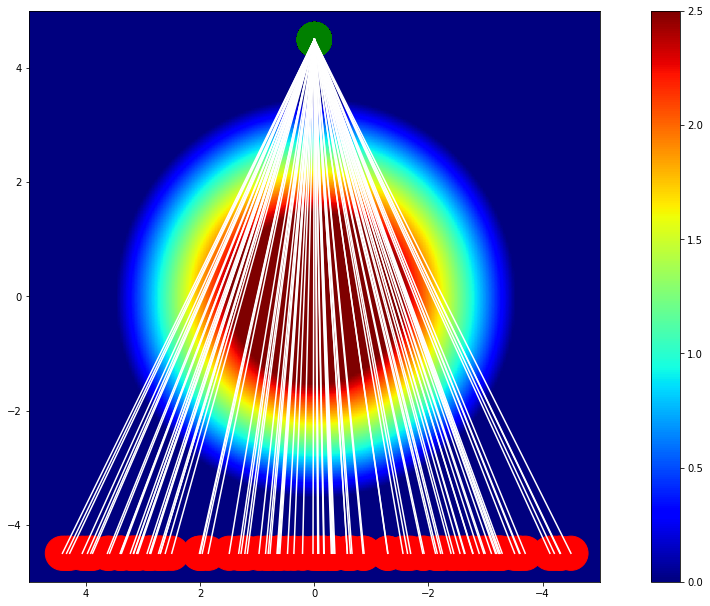

In [24]:
map_1, resolution = read_map("map_1.xml")
starts_map_1, goals_map_1 = read_tasks("tasks_map_1_1.xml")
robot_size = 0.3
draw_all_tasks(map_1, resolution, starts_map_1, goals_map_1, robot_size)

### Карта 2

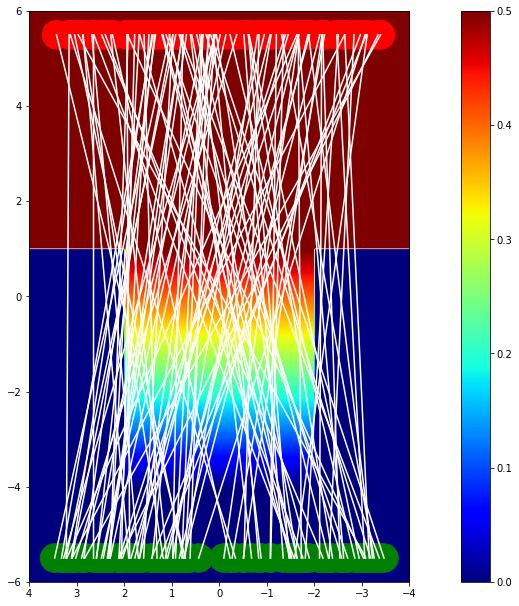

In [25]:
map_2, resolution = read_map("map_2.xml")
starts_map_2, goals_map_2 = read_tasks("tasks_map_2.xml")
robot_size = 0.3
draw_all_tasks(map_2, resolution, starts_map_2, goals_map_2, robot_size)

### Карта 3

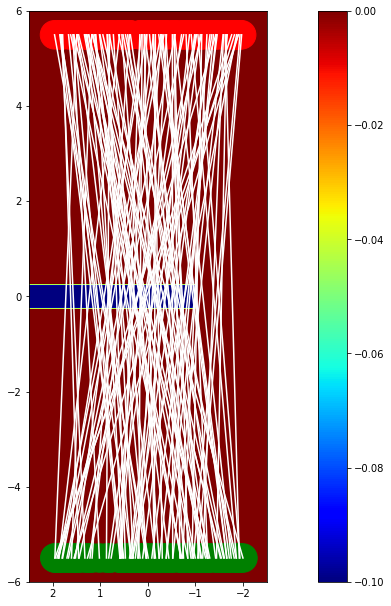

In [26]:
map_3, resolution = read_map("map_3.xml")
starts_map_3, goals_map_3 = read_tasks("tasks_map_3.xml")
robot_size = 0.3
draw_all_tasks(map_3, resolution, starts_map_3, goals_map_3, robot_size)

## Чтение результатов

### Визуализация

In [27]:
def draw_result(result_dir, result_prefix, task_number, height_map, resolution, starts, goals, robot_size):

    fig, ax = draw_map_2d(height_map, resolution)
    start = starts_map_1[task_number]
    goal = goals_map_1[task_number]


    start_circ = plt.Circle((start[1], start[0]), size, color='g')
    ax.add_patch(start_circ)
    goal_circ = plt.Circle((goal[1], goal[0]), size, color='r')
    ax.add_patch(goal_circ)
    plt.plot([start[1], goal[1]], [start[0], goal[0]], color='c')

    xs, ys, yaws, success = read_path_x_y_yaw_s(result_dir + result_prefix + str(task_number) + ".txt")
    print(success)

    path = convert_path_to_x_y_z(xs, ys, resolution, map_1)


    plt.plot(path[:, 1], path[:, 0], color='w')   
    for step in range(len(xs)):
        circ = plt.Circle((ys[step], xs[step]), size, color='w', alpha=0.1)
        ax.add_patch(circ)

   

True


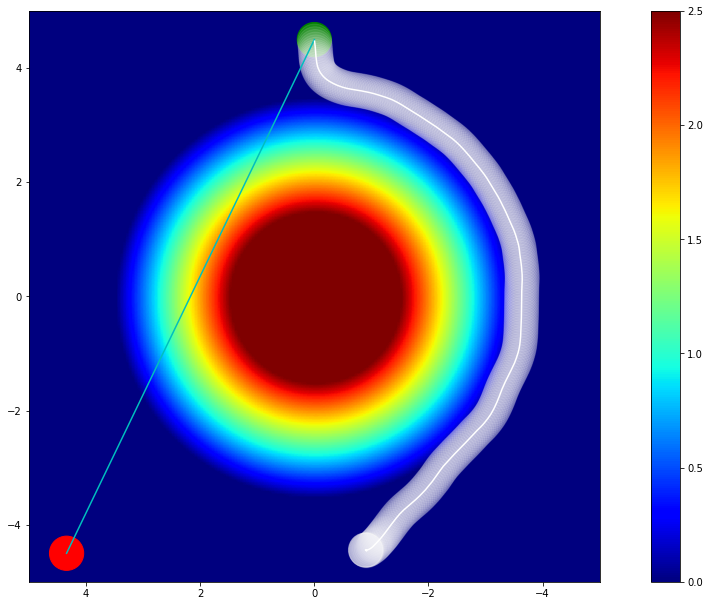

In [28]:
result_dir = "/home/sadergachev/Documents/Projects/uneven_navigation/src/dtl_metalbot/ros2_ws/src/experiment_slp_rgh_1/"
result_prefix = "result_task_"
task_number = 50

draw_result(result_dir, result_prefix, task_number, map_1, resolution, starts_map_1, goals_map_1, 0.3)

True


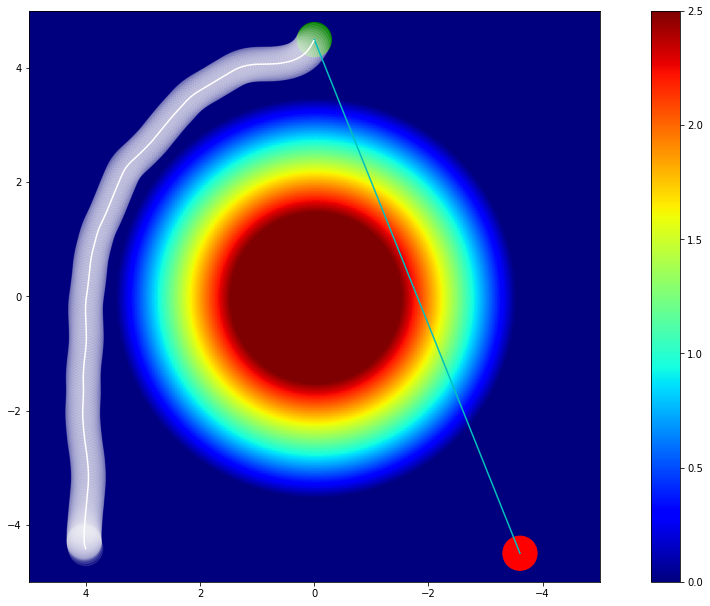

In [29]:


result_dir = "/home/sadergachev/Documents/Projects/uneven_navigation/src/dtl_metalbot/ros2_ws/src/experiment_trav_1/"
result_prefix = "result_task_"
task_number = 0


draw_result(result_dir, result_prefix, task_number, map_1, resolution, starts_map_1, goals_map_1, 0.3)

### Обработка результатов

In [44]:
number_of_results = 5
number_of_tasks = 100

success_table = np.zeros((number_of_tasks, number_of_results))
len_table = np.zeros((number_of_tasks, number_of_results))
sim_time_table = np.zeros((number_of_tasks, number_of_results))
dz_table = np.zeros((number_of_tasks, number_of_results))
slp_table = np.zeros((number_of_tasks, number_of_results))
rgh_table = np.zeros((number_of_tasks, number_of_results))

dt = 0.1


def compute_metrics(result_dir, result_prefix, number_of_tasks, dt, result_id):
    for i in range(number_of_tasks):
        result_file = result_dir + result_prefix + str(i) + ".txt"
        xs, ys, yaws, success = read_path_x_y_yaw_s(result_file)
        success_table[i, result_id] = int(success)

        path = convert_path_to_x_y_z(xs, ys, resolution, map_1)
        len_table[i, result_id] = path_len(path)
        sim_time_table[i, result_id] = sim_time(path, dt)
        dz_table[i, result_id] = max_height_diff(path)
        s,r = max_slope_roughness(map_1, path, size, resolution)
        slp_table[i, result_id] = s
        rgh_table[i, result_id] = r

In [45]:
result_dir = "/home/sadergachev/Documents/Projects/uneven_navigation/src/dtl_metalbot/ros2_ws/src/experiment_slp_rgh_1/"
result_prefix = "result_task_"

compute_metrics(result_dir, result_prefix, number_of_tasks, dt, 0)

/tmp/ipykernel_179213/397666652.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (a, b, c), resid, rank, s = np.linalg.lstsq(G, Z)


In [46]:
result_dir = "/home/sadergachev/Documents/Projects/uneven_navigation/src/dtl_metalbot/ros2_ws/src/experiment_slp_rgh_2/"
result_prefix = "result_task_"

compute_metrics(result_dir, result_prefix, number_of_tasks, dt, 1)

/tmp/ipykernel_179213/397666652.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (a, b, c), resid, rank, s = np.linalg.lstsq(G, Z)


In [47]:
for i in range(number_of_results):
    print(np.sum(success_table[:, i])/number_of_tasks)

0.94
0.9
0.0
0.0
0.0


In [48]:
common_count = 0
sum_len = np.zeros(number_of_results)
sum_sim_time = np.zeros(number_of_results)
sum_dz = np.zeros(number_of_results)
sum_slp = np.zeros(number_of_results)
sum_rgh = np.zeros(number_of_results)

for i in range(number_of_tasks):
    if success_table[i, 0] == 1 and success_table[i, 1] == 1:
        common_count += 1
        sum_len += len_table[i, :]
        sum_sim_time += sim_time_table[i, :]
        sum_dz += dz_table[i, :]
        sum_slp += slp_table[i, :]
        sum_rgh += rgh_table[i, :]
        
print(sum_len / common_count)
print(sum_sim_time / common_count)
print(sum_dz / common_count)
print(sum_slp / common_count)
print(sum_rgh / common_count)

[11.21421043 11.16312723  0.          0.          0.        ]
[26.40344828 25.57471264  0.          0.          0.        ]
[0. 0. 0. 0. 0.]
[0.17062461 0.13211932 0.         0.         0.        ]
[0.03017711 0.02572794 0.         0.         0.        ]
